In [1]:
import torch 

import torch.nn as nn

import time 

import numpy as np

import matplotlib.pyplot as plt

In [2]:
start = time.time()

def CreateData(min_len,max_len,n):
    
     data = []
     labels = []
        
     for i in range(n):
        
        point_len = torch.randint(min_len,max_len,(1,)).item() # Generating random length of input
        
        randm_sq = torch.rand((1,point_len)) # Generating the random sequence
        
        indices = np.random.choice(point_len,2,replace = False) # Picking two distinct numbers in [1,point_len]
        
        label_smp = randm_sq[0][indices[0]] + randm_sq[0][indices[1]] # True label of sample
        
        indices = torch.from_numpy(indices) 
        
        bit_map = torch.zeros(1,point_len).index_fill_(1,indices,1) # Generating the bit map
        
        data_smp = torch.cat((randm_sq,bit_map)) # concatenate bit map and random seq
        
        data.append(data_smp) # appending the data to list
        
        labels.append(label_smp.view(1,1)) # appending the label to list
        
     return data,labels   
        

In [3]:
min_len_train = 2 # Min length of input seq

max_len_train = 9 # Max length of input seq

no_train_smps = 6000

data,labels = CreateData(min_len_train,max_len_train,no_train_smps) # Creating the Data to train.

### Elman RNN 

> Parameters in Elman RNN can be denoted as U (between input and hidden state) , W (hidden to hidden state) and V (hidden and output state).


In [4]:
class Elman_RNN(nn.Module):
    
    def __init__(self,input_dim,hidden_dim,output_dim):
        
        super().__init__()
        
        # Initialsing
        self.hdim  = hidden_dim
        self.xdim  = input_dim
        self.ydim  = output_dim
        self.h_0 = torch.zeros(self.hdim,1)
        
        # Parameters in the model
        self.U = nn.Parameter(torch.randn(self.hdim,self.xdim)/(np.sqrt(self.xdim)))
        self.bias_h = nn.Parameter(torch.rand(self.hdim,1))
        self.W = nn.Parameter(torch.randn(self.hdim,self.hdim)/(np.sqrt(self.hdim)))
        self.V = nn.Parameter(torch.randn(self.ydim,self.hdim)/(np.sqrt(self.hdim)))
        self.bias_y = nn.Parameter(torch.rand(self.ydim,1))
        
        
    def forward(self,input_sq):
        """
       forward method expects the input sequence of n x input_dim, where n is the no. of elements in the input sequence of depth input_dim.
       """
        self.h_t = self.h_0
        Tanh = nn.Tanh()

        for input_ in input_sq:
            
           input_ = input_.view(-1,1)

           self.h_t = Tanh(self.U@input_ + self.W@self.h_t + self.bias_h) # Calculating the new hidden state
        
        self.y_smp = self.V@self.h_t + self.bias_y # Predicted Output
       
        return self.y_smp
    
    def train_loop(self,X,y,num_epochs,lr = 0.05):
        
        # Using MSE loss
        loss_fn = nn.MSELoss()
        
        # Using SGD to update parameters
        optimizer = torch.optim.SGD(self.parameters(),lr = lr)
        
        loss_lst = [] # list to store loss after each epoch. 
        
        no_train_smps = len(X) # Total no. of samples

        for epoch in range(num_epochs+1):
    
           total_loss = 0 # To calculate total loss after each epoch.
        
           # Shuffling the data in every epoch.
           combined_data = list(zip(X,y))
           np.random.shuffle(combined_data)
           shuffle_data,shuffle_labels = zip(*combined_data)
    
           for i in range(no_train_smps):
             
             if epoch == 0 :
               # Calculating the loss before learning.
               output = self.forward(shuffle_data[i].T) # Output predicted by the model
               loss = loss_fn(output,shuffle_labels[i]) # MSE loss
               total_loss = total_loss + (loss.detach()).item() # Total loss updated
            
             else :
                 # Making gradients w.r.t parameters '0' after each epoch to avoid accumulation of gradients.
                 optimizer.zero_grad()
        
                 output = self.forward(shuffle_data[i].T)# Model prediction 
      
                 loss = loss_fn(output,shuffle_labels[i]) # MSE loss
      
                 total_loss = total_loss + (loss.detach()).item() # Total loss is updated after each epoch
    
                 loss.backward() # Backward pass for gradient of loss w.r.t parameters in model. 
    
                 optimizer.step() # Updating the parameters 
        
           total_loss = (total_loss)/(no_train_smps) 
           print("Training loss of RNN after Epoch {} : {}".format(epoch,total_loss))
           loss_lst.append(total_loss) # Appending the loss after each epoch
            
        return loss_lst

In [5]:
# According the problem in the hand.

input_dim = 2

hidden_dim = 5 # Hand Picked

output_dim = 1


my_RNN = Elman_RNN(input_dim,hidden_dim,output_dim)

In [6]:
start_time_rnn = time.time()  # To calculate start time of RNN

num_epochs = 30

rnn_loss_lst  = my_RNN.train_loop(data,labels,num_epochs)

end_time_rnn = time.time()  # To calculate end time of RNN

time_rnn = end_time_rnn - start_time_rnn # Time taken by rnn

Training loss of RNN after Epoch 0 : 1.2078196536988446
Training loss of RNN after Epoch 1 : 0.07595367766162792
Training loss of RNN after Epoch 2 : 0.017857815904676517
Training loss of RNN after Epoch 3 : 0.015342125310881414
Training loss of RNN after Epoch 4 : 0.013515561880885076
Training loss of RNN after Epoch 5 : 0.013421865030487505
Training loss of RNN after Epoch 6 : 0.012702209990026537
Training loss of RNN after Epoch 7 : 0.012509395389086976
Training loss of RNN after Epoch 8 : 0.010940460972925557
Training loss of RNN after Epoch 9 : 0.00966629830104117
Training loss of RNN after Epoch 10 : 0.008640036185282874
Training loss of RNN after Epoch 11 : 0.008986101452969197
Training loss of RNN after Epoch 12 : 0.008078996671950542
Training loss of RNN after Epoch 13 : 0.007898807925687706
Training loss of RNN after Epoch 14 : 0.007194810589769631
Training loss of RNN after Epoch 15 : 0.007311094288771971
Training loss of RNN after Epoch 16 : 0.007259871990799804
Training lo

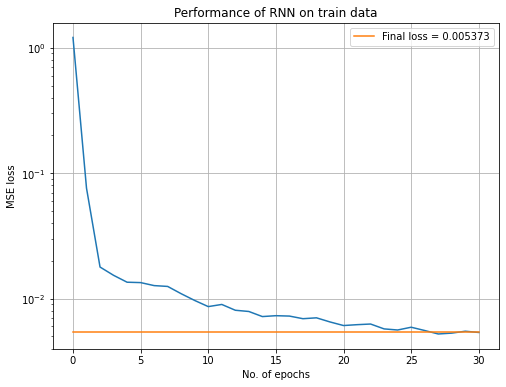

In [39]:
# Performance of the RNN on train data.

Final_loss_rnn = np.full(num_epochs +1,np.round(rnn_loss_lst[-1],decimals = 6))
final_rnn = np.round(rnn_loss_lst[-1],decimals = 6)

plt.figure(figsize = (8,6))

plt.grid()
plt.plot(np.arange(num_epochs+1),rnn_loss_lst)
plt.plot(np.arange(num_epochs+1),Final_loss_rnn,label = "Final loss = {}".format(final_rnn))

plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("MSE loss")
plt.title("Performance of RNN on train data")
plt.yscale('log')

plt.show()

## LSTM (Long Short Term Memory)

In [8]:
class LSTM(nn.Module):
    
    def __init__(self,input_dim,cell_dim,hidden_dim,output_dim):
        
        super().__init__()
        
        # Initialising 
        self.Cdim  = cell_dim
        self.hdim  = hidden_dim
        self.xdim  = input_dim
        self.ydim  = output_dim
        self.h_0 = torch.zeros(self.hdim,1)
        self.C_0 = torch.zeros(self.Cdim,1)
        
        # FORGET GATE PARAMETERS
        
        self.Wf = nn.Parameter(torch.randn(self.Cdim,self.xdim + self.hdim)/(np.sqrt(self.xdim + self.hdim)))
        self.bias_f = nn.Parameter(torch.rand(self.Cdim,1))
        
        # INPUT GATE PARAMETERS
        
        self.Wi = nn.Parameter(torch.randn(self.Cdim,self.xdim + self.hdim)/(np.sqrt(self.xdim + self.hdim)))
        self.Wc = nn.Parameter(torch.randn(self.Cdim,self.xdim + self.hdim)/(np.sqrt(self.xdim + self.hdim)))
        self.bias_i = nn.Parameter(torch.rand(self.Cdim,1))
        self.bias_c = nn.Parameter(torch.rand(self.Cdim,1))
        
        # OUTPUT GATE PARAMETERS
        
        self.Wo = nn.Parameter(torch.randn(self.Cdim,self.xdim + self.hdim)/(np.sqrt(self.xdim + self.hdim)))
        self.bias_o = nn.Parameter(torch.rand(self.Cdim,1))
        
        # FINAL OUTPUT PARAMETERS
        
        self.Wy = nn.Parameter(torch.randn(self.ydim,self.hdim)/(np.sqrt(self.hdim)))
        self.bias_y = nn.Parameter(torch.rand(self.ydim,1))
        
        
    def forward(self,input_sq):
        """
       forward method expects the input sequence of n x input_dim, where n is the no. of elements in the input sequence of depth input_dim.
       
       """
        # Initialised the cell state and hidden state.
        self.h_t = self.h_0
        self.C_t = self.C_0
        
        Tanh = nn.Tanh() # Tanh non-linearity
        Sigmoid = nn.Sigmoid() # Sigmoid non-linearity

        for input_ in input_sq:
            
           input_ = input_.view(-1,1) # Adjusting the input to appropriate shape
        
           concat_vec = torch.cat((self.h_t,input_)) # Concatenating the hidden state and input  
           
           self.f_t = Sigmoid(self.Wf@concat_vec + self.bias_f) # To do selective erase of prev hidden state
           self.i_t = Sigmoid(self.Wi@concat_vec + self.bias_i) # To do selective read from prev hidden state
            
           cand = Tanh(self.Wc@concat_vec + self.bias_c) # Candidate cell state
           
           self.C_t = self.C_t*self.f_t + self.i_t*cand # New cell state
           self.o_t = Sigmoid(self.Wo@concat_vec + self.bias_o) # To do selective write on prev hidden write
           self.h_t = Tanh(self.C_t)*self.o_t # New hidden state
        
        self.y_smp = self.Wy@self.h_t + self.bias_y # Output predicted by model
        
        return self.y_smp
    
    def train_loop(self,X,y,num_epochs,lr = 0.05):
        
        # Using MSE loss
        loss_fn = nn.MSELoss()
        
        # Using SGD to update parameters
        optimizer = torch.optim.SGD(self.parameters(),lr = lr)
        
        loss_lst = [] # list to store loss after each epoch. 
        
        no_train_smps = len(X) # Total no. of samples

        for epoch in range(num_epochs+1):
    
           total_loss = 0 # To calculate total loss after each epoch.
        
           # Shuffling the data in every epoch.
           combined_data = list(zip(X,y))
           np.random.shuffle(combined_data)
           shuffle_data,shuffle_labels = zip(*combined_data)
    
           for i in range(no_train_smps):
             
             if epoch == 0 :
               # Calculating the loss before learning.
               output = self.forward(shuffle_data[i].T) # Output predicted by the model
               loss = loss_fn(output,shuffle_labels[i]) # MSE loss
               total_loss = total_loss + (loss.detach()).item() # Total loss updated
            
             else :
                 # Making gradients w.r.t parameters '0' after each epoch to avoid accumulation of gradients.
                 optimizer.zero_grad()
        
                 output = self.forward(shuffle_data[i].T)# Model prediction 
      
                 loss = loss_fn(output,shuffle_labels[i]) # MSE loss
      
                 total_loss = total_loss + (loss.detach()).item() # Total loss is updated after each epoch
    
                 loss.backward() # Backward pass for gradient of loss w.r.t parameters in model. 
    
                 optimizer.step() # Updating the parameters 
        
           total_loss = (total_loss)/(no_train_smps) 
           print("Training loss of LSTM after Epoch {} : {}".format(epoch,total_loss))
           loss_lst.append(total_loss) # Appending the loss after each epoch
            
        return loss_lst

In [9]:
# According to the problem in hand

input_dim = 2

hidden_dim = 5 # Hand Picked

cell_dim = 5 # Hand Picked (In general cell_dim = hidden_dim)

output_dim = 1


my_LSTM = LSTM(input_dim,cell_dim,hidden_dim,output_dim)

In [10]:
# Training the LSTM

start_time_lstm = time.time() # To calculate start time of lstm

num_epochs = 30

lstm_loss_lst  = my_LSTM.train_loop(data,labels,num_epochs)

end_time_lstm = time.time() # To calculate end time of lstm

time_lstm = end_time_lstm - start_time_lstm  # Time taken by the LSTM 

Training loss of LSTM after Epoch 0 : 0.6082444860130446
Training loss of LSTM after Epoch 1 : 0.060712202559813494
Training loss of LSTM after Epoch 2 : 0.003983750224069809
Training loss of LSTM after Epoch 3 : 0.002479700258435095
Training loss of LSTM after Epoch 4 : 0.0019286306264500693
Training loss of LSTM after Epoch 5 : 0.0014973981448757143
Training loss of LSTM after Epoch 6 : 0.0013213806735756187
Training loss of LSTM after Epoch 7 : 0.0011432147859834626
Training loss of LSTM after Epoch 8 : 0.0009557177989707484
Training loss of LSTM after Epoch 9 : 0.0008414438210348379
Training loss of LSTM after Epoch 10 : 0.0007600395673916599
Training loss of LSTM after Epoch 11 : 0.0006877350152118544
Training loss of LSTM after Epoch 12 : 0.0006366128100727534
Training loss of LSTM after Epoch 13 : 0.0005948998642229097
Training loss of LSTM after Epoch 14 : 0.0005489427190438262
Training loss of LSTM after Epoch 15 : 0.0005076045398905893
Training loss of LSTM after Epoch 16 : 0

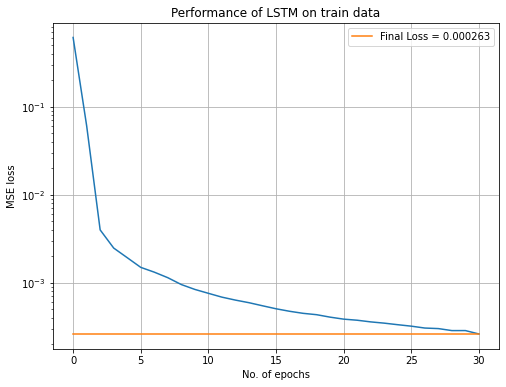

In [37]:
# Performance of the LSTM on train data.

Final_loss_lstm = np.full(num_epochs +1,np.round(lstm_loss_lst[-1],decimals = 6))
lstm_ls = np.round(lstm_loss_lst[-1],decimals = 6)
plt.figure(figsize = (8,6))
plt.grid()
plt.plot(np.arange(num_epochs+1),lstm_loss_lst)
plt.plot(np.arange(num_epochs+1),Final_loss_lstm,label = "Final Loss = {}".format(lstm_ls))

plt.xlabel("No. of epochs")
plt.ylabel("MSE loss")
plt.legend()
plt.yscale('log')
plt.title("Performance of LSTM on train data")

plt.show()

## GRU(Gated Recurrent Unit)

In [12]:
class GRU(nn.Module):
    
      def __init__(self,input_dim,hidden_dim,output_dim):
        
        super().__init__()
        
        # Initialising
        self.hdim  = hidden_dim
        self.xdim  = input_dim
        self.ydim  = output_dim
        self.h_0 = torch.zeros(self.hdim,1)
        
        # RESET GATE PARAMETERS
        
        self.Wr = nn.Parameter(torch.randn(self.hdim,self.xdim + self.hdim)/(np.sqrt(self.xdim+self.hdim)))
        self.bias_r = nn.Parameter(torch.rand(self.hdim,1))
        
        # UPDATE GATE PARAMETERS
        
        self.Wz = nn.Parameter(torch.randn(self.hdim,self.xdim + self.hdim)/(np.sqrt(self.xdim+self.hdim)))
        self.Wch = nn.Parameter(torch.randn(self.hdim,self.xdim + self.hdim)/(np.sqrt(self.xdim+self.hdim)))
        self.bias_z = nn.Parameter(torch.rand(self.hdim,1))
        self.bias_ch = nn.Parameter(torch.rand(self.hdim,1))
        
        # FINAL OUTPUT PARAMETERS
        
        self.Wy =  nn.Parameter(torch.randn(self.ydim,self.hdim)/(np.sqrt(self.hdim)))
        self.bias_y = nn.Parameter(torch.rand(self.ydim,1))
        
      def forward(self,input_sq):
        """
       forward method expects the input sequence of n x input_dim, where n is the no. of elements in the input sequence of depth input_dim.
       
       """
        
        self.h_t = self.h_0
        
        Tanh = nn.Tanh()
        Sigmoid = nn.Sigmoid()

        for input_ in input_sq:
            
           input_ = input_.view(-1,1)
        
           concat_vec1 = torch.cat((self.h_t,input_)) # Concatenating the hidden state and input
            
           self.r_t = Sigmoid(self.Wr@concat_vec1 + self.bias_r) # To reset the hidden state
           reset_hid = self.r_t*self.h_t # Reseted hidden state.
        
           concat_vec2 = torch.cat((reset_hid,input_)) # Concatenating the reseted hidden state and input
           cand_hid = Tanh(self.Wch@concat_vec2 + self.bias_ch) # Candidate hidden state
        
           self.z_t = Sigmoid(self.Wz@concat_vec1 + self.bias_z) # To update the hidden state
           self.h_t = (1 - self.z_t)*self.h_t + self.z_t*cand_hid  # Updated hidden state
        
        self.y_smp = self.Wy@self.h_t + self.bias_y # Predicting the output
       
        return self.y_smp
    
      def train_loop(self,X,y,num_epochs,lr = 0.05):
        
        # Using MSE loss
        loss_fn = nn.MSELoss()
        
        # Using SGD to update parameters
        optimizer = torch.optim.SGD(self.parameters(),lr = lr)
        
        loss_lst = [] # list to store loss after each epoch. 
        
        no_train_smps = len(X) # Total no. of samples

        for epoch in range(num_epochs+1):
    
           total_loss = 0 # To calculate total loss after each epoch.
        
           # Shuffling the data in every epoch.
           combined_data = list(zip(X,y))
           np.random.shuffle(combined_data)
           shuffle_data,shuffle_labels = zip(*combined_data)
    
           for i in range(no_train_smps):
             
             if epoch == 0 :
               # Calculating the loss before learning.
               output = self.forward(shuffle_data[i].T) # Output predicted by the model
               loss = loss_fn(output,shuffle_labels[i]) # MSE loss
               total_loss = total_loss + (loss.detach()).item() # Total loss updated
            
             else :
                 # Making gradients w.r.t parameters '0' after each epoch to avoid accumulation of gradients.
                 optimizer.zero_grad()
        
                 output = self.forward(shuffle_data[i].T)# Model prediction 
      
                 loss = loss_fn(output,shuffle_labels[i]) # MSE loss
      
                 total_loss = total_loss + (loss.detach()).item() # Total loss is updated after each epoch
    
                 loss.backward() # Backward pass for gradient of loss w.r.t parameters in model. 
    
                 optimizer.step() # Updating the parameters 
        
           total_loss = (total_loss)/(no_train_smps) 
           print("Training loss of GRU after Epoch {} : {}".format(epoch,total_loss))
           loss_lst.append(total_loss) # Appending the loss after each epoch
            
        
        return loss_lst

In [13]:
# According to the problem in hand

input_dim = 2

hidden_dim = 5 # Hand Picked

output_dim = 1


my_GRU = GRU(input_dim,hidden_dim,output_dim)

In [14]:
# Training the GRU

start_time_gru = time.time() # To calculate start time of GRU

num_epochs = 30

gru_loss_lst  = my_GRU.train_loop(data,labels,num_epochs)

end_time_gru = time.time() # To calculate end time of GRU

time_gru = end_time_gru - start_time_gru # Time taken by GRU 

Training loss of GRU after Epoch 0 : 0.544993598575412
Training loss of GRU after Epoch 1 : 0.04102904054704698
Training loss of GRU after Epoch 2 : 0.002210196418136898
Training loss of GRU after Epoch 3 : 0.0012734574935567118
Training loss of GRU after Epoch 4 : 0.0008961675489894941
Training loss of GRU after Epoch 5 : 0.0007424762966409441
Training loss of GRU after Epoch 6 : 0.0006302214665684686
Training loss of GRU after Epoch 7 : 0.0005405162542813861
Training loss of GRU after Epoch 8 : 0.00047949025708027726
Training loss of GRU after Epoch 9 : 0.0004477553638416136
Training loss of GRU after Epoch 10 : 0.0003993181383316795
Training loss of GRU after Epoch 11 : 0.00036361594277986066
Training loss of GRU after Epoch 12 : 0.00032789942162210944
Training loss of GRU after Epoch 13 : 0.0003028005635904443
Training loss of GRU after Epoch 14 : 0.0002832376145826044
Training loss of GRU after Epoch 15 : 0.0002579412425853048
Training loss of GRU after Epoch 16 : 0.00023901743428

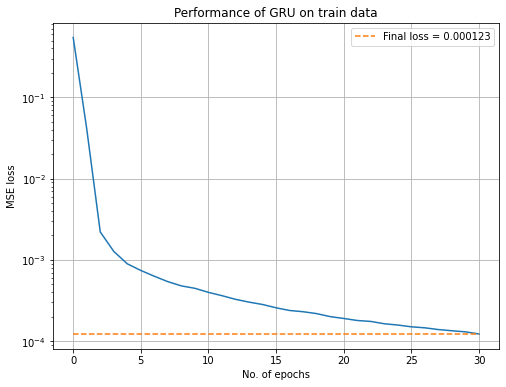

In [36]:
# Performance of the GRU on train data.

Final_loss_gru = np.full(num_epochs +1,np.round(gru_loss_lst[-1],decimals = 6))
final_gru = np.round(gru_loss_lst[-1],decimals = 6)

plt.figure(figsize = (8,6))

plt.grid()

plt.plot(np.arange(num_epochs+1),gru_loss_lst)
plt.plot(np.arange(num_epochs+1),Final_loss_gru,linestyle = '--',label = 'Final loss = {}'.format(final_gru))
plt.xlabel("No. of epochs")
plt.ylabel("MSE loss")
plt.legend()
plt.yscale('log')
plt.title("Performance of GRU on train data")

plt.show()

## Performance Comparison with Baseline Model

In [16]:
# Baseline model always predicts '1' as the label for the input sequence


# For Training Data 

base_pred   = torch.ones(len(data),1)

labels_ = torch.tensor(labels).view(-1,1)

loss_func = nn.MSELoss()

base_loss = loss_func(base_pred,labels_).item()

print("Loss incurred by the base-line model on training data is",base_loss)

Loss incurred by the base-line model on training data is 0.16469626128673553


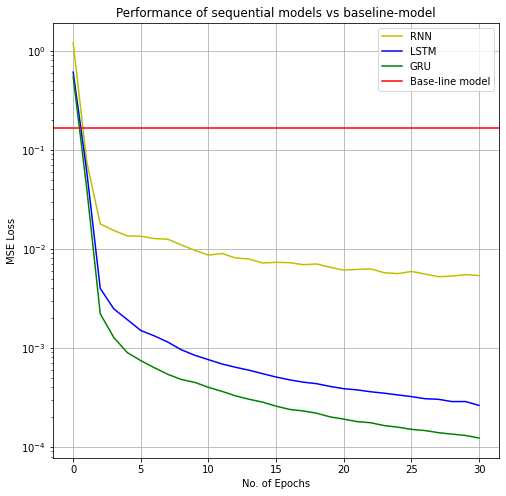

In [17]:
# Plot of training loss of all sequential models vs base-line loss

plt.figure(figsize = (8,8))

plt.grid()

plt.plot(np.arange(num_epochs+1),rnn_loss_lst,color = 'y',label = "RNN")
plt.plot(np.arange(num_epochs+1),lstm_loss_lst,color = 'b',label = "LSTM")
plt.plot(np.arange(num_epochs+1),gru_loss_lst,color = 'g',label = "GRU")
plt.axhline(y = base_loss,color = "r", label = "Base-line model")

plt.legend()
plt.xlabel("No. of Epochs")
plt.ylabel("MSE Loss")
plt.title("Performance of sequential models vs baseline-model")
plt.yscale('log')
plt.show()

## Comparing the time taken to train the data


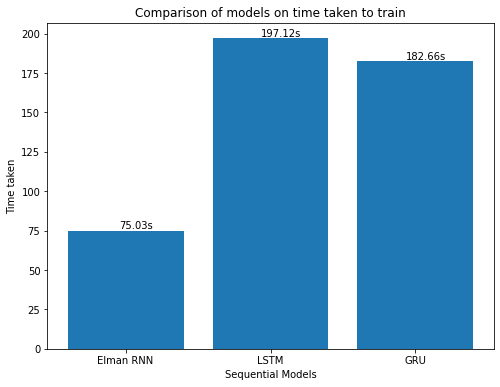

In [18]:
models = np.array(["Elman RNN","LSTM","GRU"])

time_lst = np.array([time_rnn,time_lstm,time_gru])

plt.figure(figsize = (8,6))

bars = plt.bar(models,time_lst)
    
plt.xlabel("Sequential Models")
plt.ylabel("Time taken")
plt.title("Comparison of models on time taken to train")

for bar in bars:
    height = np.round(bar.get_height(),decimals = 2)
    plt.text((bar.get_x() + bar.get_width()/1.7), height, f'{height}'+'s',ha ='center', va ='bottom')
    
plt.show()

- As we can see GRU is time efficient by compromising performance (some times) compared to LSTM

## Testing 

In [19]:
# Testing Data 

min_len_test = 2  

max_len_test = 15 # (max length is increased compared to training to see how better the model will generalise)

no_test_smps = 2000

test_data,test_labels = CreateData(min_len_test,max_len_test,no_test_smps) # Creating the data to test.

In [20]:
# Performance of base line on test data

base_pred_test   = torch.ones(len(test_data),1)

test_labels_ = torch.tensor(test_labels).view(-1,1)

loss_func = nn.MSELoss()

base_loss_test = loss_func(base_pred_test,test_labels_)

base_loss_test = base_loss_test.item()

print("Loss incurred by the base-line model on testing data is",base_loss_test)

Loss incurred by the base-line model on testing data is 0.16165854036808014


In [21]:
# Performance of Elman RNN on Test Data

loss_fn = nn.MSELoss()

test_loss_rnn = 0
    
my_RNN.eval()

with torch.no_grad():
  
   for i in range(no_test_smps):
        
      output = my_RNN(test_data[i].T)
      
      loss_rnn = loss_fn(output,test_labels[i])
      
      test_loss_rnn = test_loss_rnn + loss_rnn
    
   test_loss_rnn = ((test_loss_rnn)/(no_test_smps)).item()
   print("Loss incurred by the Elman RNN on testing data is",test_loss_rnn)

Loss incurred by the Elman RNN on testing data is 0.010143366642296314


In [22]:
# Performance of LSTM on Test Data

loss_fn = nn.MSELoss()

test_loss_lstm = 0
    
my_LSTM.eval()

with torch.no_grad():
  
   for i in range(no_test_smps):
        
      output = my_LSTM(test_data[i].T)
      
      loss_lstm = loss_fn(output,test_labels[i])
      
      test_loss_lstm = test_loss_lstm + loss_lstm
    
   test_loss_lstm = ((test_loss_lstm)/(no_test_smps)).item()
   print("Loss incurred by the LSTM on testing data is",test_loss_lstm)

Loss incurred by the LSTM on testing data is 0.00137105502653867


In [23]:
# Performance of GRU on Test Data

loss_fn = nn.MSELoss()

test_loss_gru = 0
    
my_GRU.eval()

with torch.no_grad():
  
   for i in range(no_test_smps):
        
      output = my_GRU(test_data[i].T)
      
      loss_gru = loss_fn(output,test_labels[i])
      
      test_loss_gru = test_loss_gru + loss_gru
    
   test_loss_gru = ((test_loss_gru)/(no_test_smps)).item()

   print("Loss incurred by the GRU on testing data is",test_loss_gru)

Loss incurred by the GRU on testing data is 0.0006575118750333786


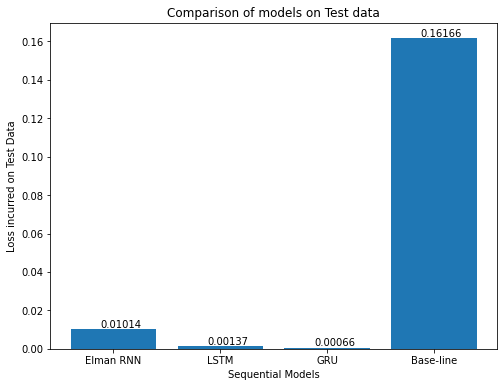

In [24]:
# Plot of testing loss of sequential models vs base-line

models = np.array(["Elman RNN","LSTM","GRU","Base-line"])

test_ls = np.array([test_loss_rnn,test_loss_lstm,test_loss_gru,base_loss_test])

plt.figure(figsize = (8,6))

bars = plt.bar(models,test_ls)
    
plt.xlabel("Sequential Models")
plt.ylabel("Loss incurred on Test Data")

for bar in bars:
    height = np.round(bar.get_height(),decimals = 5)
    plt.text((bar.get_x() + bar.get_width()/1.7), height, f'{height}',ha ='center', va ='bottom')

plt.title("Comparison of models on Test data")

plt.show()

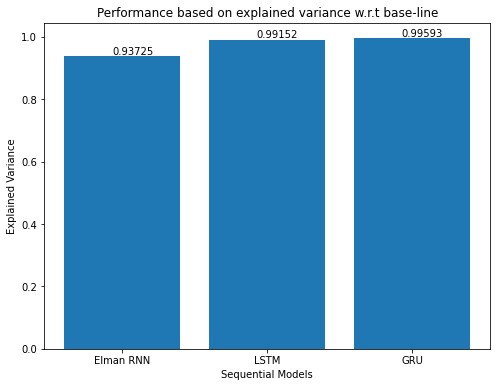

In [25]:
# Explained Variance of three models

seq_models = np.array(["Elman RNN","LSTM","GRU"])
                      
exp_var = 1 - test_ls[:3]/(base_loss_test)

plt.figure(figsize = (8,6))                
bars = plt.bar(seq_models,exp_var)

plt.xlabel("Sequential Models")
plt.ylabel("Explained Variance")
plt.title("Performance based on explained variance w.r.t base-line")

for bar in bars:
    height = np.round(bar.get_height(),decimals = 5)
    plt.text((bar.get_x() + bar.get_width()/1.7), height, f'{height}',ha ='center', va ='bottom')
                      
plt.show()

In [26]:
end = time.time()
print("Total time taken to run the whole code : {}".format(end-start))

Total time taken to run the whole code : 458.7232897281647
